**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 4: Confusion Matrix

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Load Data

For the example's sake we here don't split further in a validation set. Just compute the confusion matrix based on prediction for the test data.

In [2]:
training_data = datasets.mnist.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.MNIST(root="data", train=False, download=True, transform=ToTensor())

### Model

Specify your favorite MLP as determined in one of the previous execises.

In [3]:
def get_model(complexity=200, drop_p_in=.2, drop_p_hidden=.5):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Dropout(p=drop_p_in),
        torch.nn.Linear(28*28, complexity),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(p=drop_p_hidden),
        torch.nn.Linear(complexity, 10),
        torch.nn.Sigmoid())

model = get_model(complexity=300, drop_p_in=0.3, drop_p_hidden=0.3)

In [4]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 300]         235,500
           Sigmoid-4                  [-1, 300]               0
           Dropout-5                  [-1, 300]               0
            Linear-6                   [-1, 10]           3,010
           Sigmoid-7                   [-1, 10]               0
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.91
Estimated Total Size (MB): 0.93
----------------------------------------------------------------


### Train-Validate

Specify the training / evaluation loop. Specifically, make sure that the confusion matrix is computed at the end of every epoch and remember it. 

In [5]:
def train_eval(model, lr, nepochs, nbatch, training_data, test_data):
    training_cost_hist = []; test_cost_hist = [];
    test_acc_hist = []; training_acc_hist = [];
    test_cm_hist = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)
    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    
    for epoch in range(nepochs):
        model.train()
        training_cost, correct = 0.0, 0.0
        for inputs, targets in training_loader:
            predictions = model(inputs)
            cost = cost_ce(predictions, targets)
            training_cost += cost.item()
            correct += (predictions.argmax(dim=1) == targets).type(torch.float).sum().item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        training_cost /= len(training_loader)
        training_acc = correct / len(training_loader.dataset)

        model.eval()
        test_cost, test_acc = 0.0, 0.0
        with torch.no_grad():
            inputs, targets = next(iter(test_loader))
            predictions = model(inputs)
            test_cost = cost_ce(predictions, targets).item()
            test_acc = (torch.argmax(predictions, dim=1) == targets).float().mean().item()
        
        cm = confusion_matrix(targets, torch.argmax(predictions, dim=1))
        test_cm_hist.append(cm)
        
        training_cost_hist.append(training_cost)
        training_acc_hist.append(training_acc)
        test_cost_hist.append(test_cost)
        test_acc_hist.append(test_acc)
        print("Epoch {:2}: {:.2f}, {:.2f}, {:.2f}, {:.2f}"
              .format(epoch, training_cost, test_cost, training_acc, test_acc))
    
    return training_cost_hist, test_cost_hist, training_acc_hist, test_acc_hist, test_cm_hist

### Select your favourite settings and Do the Training incl Validation Performance

In [6]:
# Configuration options
nepochs = 20
lr = 0.5
nbatch = 64

In [7]:
_, _, _, _, test_cm_hist = train_eval(model, lr, nepochs, nbatch, training_data, test_data)

Epoch  0: 1.83, 1.65, 0.68, 0.86
Epoch  1: 1.66, 1.61, 0.82, 0.87
Epoch  2: 1.63, 1.59, 0.84, 0.90
Epoch  3: 1.61, 1.57, 0.86, 0.90
Epoch  4: 1.60, 1.56, 0.87, 0.91
Epoch  5: 1.59, 1.56, 0.88, 0.91
Epoch  6: 1.58, 1.55, 0.88, 0.91
Epoch  7: 1.58, 1.55, 0.88, 0.92
Epoch  8: 1.57, 1.54, 0.89, 0.92
Epoch  9: 1.57, 1.54, 0.89, 0.92
Epoch 10: 1.57, 1.54, 0.90, 0.93
Epoch 11: 1.56, 1.53, 0.90, 0.93
Epoch 12: 1.56, 1.53, 0.90, 0.93
Epoch 13: 1.55, 1.53, 0.91, 0.93
Epoch 14: 1.55, 1.53, 0.91, 0.93
Epoch 15: 1.55, 1.52, 0.91, 0.93
Epoch 16: 1.55, 1.52, 0.91, 0.94
Epoch 17: 1.55, 1.52, 0.91, 0.94
Epoch 18: 1.54, 1.52, 0.91, 0.94
Epoch 19: 1.54, 1.52, 0.92, 0.94


### Inspect Confusion Matrix

In the given implementation below, we use seaborn for depicting the confusion matrix as a heat map. Hence, make sure to have that installed in your environment.

Note that the heatmap includes two different color scheme - one for the diagonal, one for the off-diagonal elements. 

In [8]:
import seaborn as sn

def display_cm(cf_matrix):
    plt.figure(figsize = (12,7))
    off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)
    cm = cf_matrix / np.sum(cf_matrix) * 10
    vmin = np.min(cm[~off_diag_mask])
    vmax = np.max(cm[~off_diag_mask])
    sn.heatmap(cm, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))
    plt.ylabel("label")
    plt.xlabel("prediction")
    vmin = np.min(cm[off_diag_mask])
    vmax = np.max(cm[off_diag_mask])
    sn.heatmap(cm, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
    plt.ylabel("label")
    plt.xlabel("prediction")
    #df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in range(10)], columns = [i for i in range(10)])
    #sn.heatmap(df_cm, annot=True, cmap='Blues')


<Figure size 576x360 with 0 Axes>

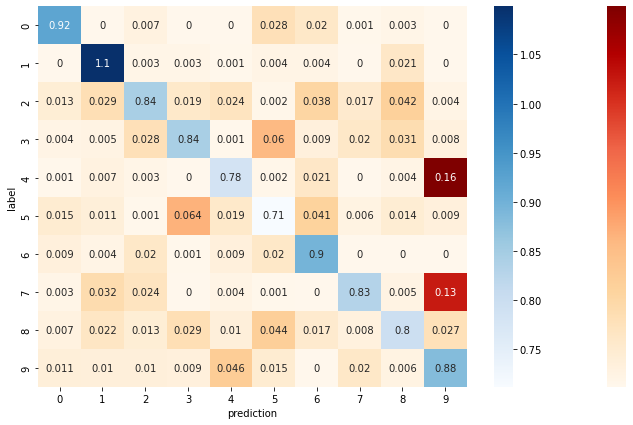

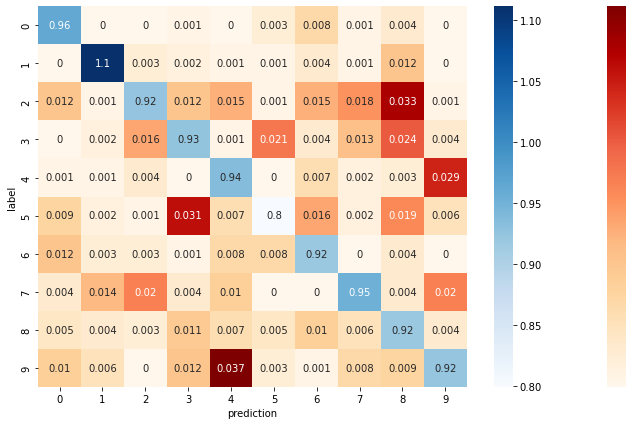

In [9]:
plt.figure(1)
display_cm(test_cm_hist[0])

plt.figure(2)
display_cm(test_cm_hist[19])

### Interpret!

Analyse how the CM evolves. Indicate what remains a problem for the model to properly classify.


The model has some problems with 4s and 7s after the first epoch. It's impressive that it gets so much right after only one epoch though. After 20 epochs accuraccy is above 80% for each class.

Looking at these two confusin matrixes it does not seem like the model improved much.

### Compute Accuracy, Precision, Recall

In [104]:
cm = test_cm_hist[19]
cm = cm / np.sum(cm) * 10
cm_diag = cm.diagonal()

In [88]:
print("class accuracy")
for i, v in enumerate(cm_diag):
    print(f"{i}: {v:.3}")

print(f"overall accuracy: {cm_diag.mean()}")

class accuracy
0: 0.963
1: 1.11
2: 0.924
3: 0.925
4: 0.935
5: 0.799
6: 0.919
7: 0.952
8: 0.919
9: 0.923
overall accuracy: 0.937


In [102]:
print("class recall")
recall_sum = 0.0
for i in range(len(cm_diag)):
    recall = cm_diag[i] / cm[[i], :].sum()
    print(f"{i}: {recall:.3}")
    recall_sum += recall

print(f"system recall: {(recall_sum / len(cm_diag)):.3}")

class recall
0: 0.983
1: 0.979
2: 0.895
3: 0.916
4: 0.952
5: 0.896
6: 0.959
7: 0.926
8: 0.944
9: 0.915
system recall: 0.936


In [103]:
print("class precision")
precision_sum = 0.0
for i in range(len(cm_diag)):
    precision = cm_diag[i] / cm[:, [i]].sum()
    print(f"{i}: {precision:.3}")
    precision_sum += precision

print(f"system precision: {(precision_sum / len(cm_diag)):.3}")

class precision
0: 0.948
1: 0.971
2: 0.949
3: 0.926
4: 0.916
5: 0.95
6: 0.934
7: 0.949
8: 0.891
9: 0.935
system recall: 0.937
